# Exercise - 3: 
### Regularization with Alpha Dropout and MC Dropout

Using the MNIST dataset, extend the previously trained deep neural network by applying
Alpha Dropout. Then, without retraining, use Monte Carlo (MC) Dropout at inference
to estimate if you can achieve better accuracy. Set random seeds to 42. Use the following
configuration:

Before that:
### What is Dropout/Alpha Dropout?
From PyTourch Documentation: 
[Dropout ](https://docs.pytorch.org/docs/stable/generated/torch.nn.Dropout.html) ,
[AlphaDropout](https://docs.pytorch.org/docs/stable/generated/torch.nn.AlphaDropout.html)


Dropout:

*During training, randomly zeroes some of the elements of the input tensor with probability p.
The zeroed elements are chosen independently for each forward call and are sampled from a Bernoulli distribution.
Each channel will be zeroed out independently on every forward call.*

AlphaDropout:

*Alpha Dropout is a type of Dropout that maintains the self-normalizing property. For an input with zero mean and unit standard deviation, the output of Alpha Dropout maintains the original mean and standard deviation of the input. Alpha Dropout goes hand-in-hand with SELU activation function, which ensures that the outputs have zero mean and unit standard deviation. During training, it randomly masks some of the elements of the input tensor with probability p using samples from a bernoulli distribution. The elements to masked are randomized on every forward call, and scaled and shifted to maintain zero mean and unit standard deviation. During evaluation the module simply computes an identity function.*



First before we try to apply Monte Carlo Dropout, lets take a look at the same DNN from Q1.

### Imports and seeding & Data prep

In [88]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split, Subset
import matplotlib.pyplot as plt
import numpy as np
import random

seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [89]:
tfm = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0,), (1,))])


train_full = datasets.MNIST('./data', train=True, download=True, transform=tfm)
test_full = datasets.MNIST('./data', train=False, download=True, transform=tfm)


train_ds, test_ds = Subset(train_full, range(1000)), Subset(test_full, range(200))
val_size = 200; train_size = len(train_ds) - val_size
train_ds, val_ds = random_split(train_ds, [train_size, val_size])

train_dl = DataLoader(train_ds, 32, True); val_dl = DataLoader(val_ds, 32); test_dl = DataLoader(test_ds, 32)


Q1's DNN with applied Alpha Dropout 

Epoch 01: Train 1.6652, Val 0.9553
Epoch 02: Train 0.7465, Val 0.6098
Epoch 03: Train 0.4316, Val 0.5430
Epoch 04: Train 0.3190, Val 0.5369
Epoch 05: Train 0.2412, Val 0.5633
Epoch 06: Train 0.2023, Val 0.5485
Epoch 07: Train 0.1541, Val 0.5488
Epoch 08: Train 0.1300, Val 0.6289
Epoch 09: Train 0.0854, Val 0.6429
Early stop.

Test Accuracy: 88.50%


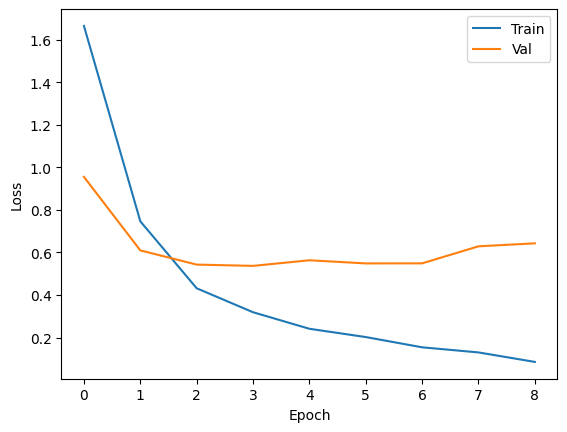

In [ ]:
class DNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(784, 64), nn.SELU(), nn.AlphaDropout(0.1),
            nn.Linear(64, 64), nn.SELU(), nn.AlphaDropout(0.1),
            nn.Linear(64, 64), nn.SELU(), nn.AlphaDropout(0.1),
            nn.Linear(64, 10)
        )

        # LeCun normal initialization
        for m in self.net:
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0.0, std=(1.0 / m.in_features) ** 0.5)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        return self.net(x)

model = DNN().to(device)

# Nadam optimizer with learning rate 0.001
opt = optim.NAdam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

patience, best, wait = 5, 1e9, 0
train_l, val_l = [], []
for e in range(50):  # 50 epochs
    model.train()
    running_loss = 0
    for x, y in train_dl:
        x, y = x.to(device), y.to(device)
        opt.zero_grad()
        loss = loss_fn(model(x), y)
        loss.backward()
        opt.step()
        running_loss += loss.item()
    tl = running_loss / len(train_dl)

    model.eval(); val_loss = 0
    with torch.no_grad():
        for x, y in val_dl:
            val_loss += loss_fn(model(x.to(device)), y.to(device)).item()
    vl = val_loss / len(val_dl)
    train_l.append(tl); val_l.append(vl)
    print(f"Epoch {e+1:02d}: Train {tl:.4f}, Val {vl:.4f}")

    if vl < best: best, wait, best_w = vl, 0, model.state_dict().copy()
    else:
        wait += 1
        if wait >= patience:
            print("Early stop.")
            break

model.load_state_dict(best_w)

# --- Test ---
model.eval(); correct = total = 0
with torch.no_grad():
    for x, y in test_dl:
        p = model(x.to(device)).argmax(1)
        correct += (p.cpu() == y).sum().item()
        total += y.size(0)
print(f"\nTest Accuracy: {100 * correct / total:.2f}%")

# --- Plot ---
plt.plot(train_l, label='Train')
plt.plot(val_l, label='Val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


With the current normalization using standardization ( mean of 0, standard deviation of 1) we achive an slightly higher (90.5% vs 89%) accuracy than our Q1 model using ELU activation function and He normalization (also called kaiming, from a guy called Kaiming He). The Alpha dropout rate at 0.1 seems to be a sweet spot, Both higher and lower give less accuracy (0.5 vs 0.1 vs 0.01) (GRAPH UNDER)